### 1. Data Loading and Exploration (3 points)
* Brief overview of the task.
* Description of the dataset used for analysis.

Brief overview of the task

In this task, we will develop an LSTM model for sentiment analysis. The main task is to understand Recurrent Neural Networks, specifically Long Short-Term Memory networks. First, we will preprocess the available data. We will convert the words into vocabulary indexes and add padding. Then, we will train the LSTM model that we wrote manually.

Description of the dataset used for analysis

For the dataset we have subset of the IMDB Movie Reviews Dataset. The dataset containing 10,000 labeled movie reviews. Each sample has a text review and corresponding output which is sentiment. Positive is 1 and negative is 0. There are 5000 postivie and 5000 negative reviews in the dataset.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data 
df = pd.read_csv('subset10000_IMDB_Dataset.csv')

# Map string labels to numerical values
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Display the first 5 rows
df.head()

,review,sentiment
0,"Starts really well, nice intro and build up fo...",0
1,"Terrific movie: If you did not watch yet, you ...",1
2,I've seen hundreds of silent movies. Some will...,1
3,i had been looking for this film for so long b...,1
4,"Good: Engaging cinematic firefights, great pre...",1


In [3]:

# Display the dataset dimensions
print("Size: " + str(df.shape))


# Define features (X) and target variable (y)
X = df['review']
y = df['sentiment']

# Print features and target variables
print("Features: ")
print(X)
print("Target Variables: ")
print(y)


Size: (10000, 2)
Features: 
0       Starts really well, nice intro and build up fo...
1       Terrific movie: If you did not watch yet, you ...
2       I've seen hundreds of silent movies. Some will...
3       i had been looking for this film for so long b...
4       Good: Engaging cinematic firefights, great pre...
                              ...                        
9995    I almost made a fool of myself when I was goin...
9996    I feel it is my duty as a lover of horror film...
9997    Why was this film made? What were the creators...
9998    If it is true that sadomasochism is a two-side...
9999    Now I did watch this when it first came out on...
Name: review, Length: 10000, dtype: object
Target Variables: 
0       0
1       1
2       1
3       1
4       1
       ..
9995    0
9996    0
9997    0
9998    1
9999    0
Name: sentiment, Length: 10000, dtype: int64


In [4]:
# Check the balance of target classes
print("Class Distribution: ")
print(df['sentiment'].value_counts())
print("\n")
# Display summary statistics
print("Statistics: ")
print(df.describe())
print("\n")
# Check for missing values
missing_values = df.isnull().sum()
print("Missing data count\n"+ str(missing_values))

Class Distribution: 
sentiment
0    5000
1    5000
Name: count, dtype: int64


Statistics: 
          sentiment
count  10000.000000
mean       0.500000
std        0.500025
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


Missing data count
review       0
sentiment    0
dtype: int64


### 2. Preprocessing the Data (7 points)

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

def prepocess_text(text):
    # Replace HTML tags with spaces
    text = re.sub(r'<.*?>', ' ', text)
    
    # Replace separators with spaces
    text = re.sub(r"[\/\\|\-_-]", " ", text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Replace non-alphabetic characters with spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Initialize stopwords and lemmatizer
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    cleaned_tokens = []
    
    for token in tokens:
        if token not in stop_words:
            # lemmatize
            if len(token) > 1: 
                lemma = lemmatizer.lemmatize(token)
                cleaned_tokens.append(lemma)

    return cleaned_tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\basri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\basri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\basri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\basri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
from sklearn.model_selection import train_test_split

# Apply preprocessing
df['tokens'] = df['review'].apply(prepocess_text)

# Split data into Train, Validation and Test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=50, stratify=df['sentiment'])
val_df, test_df = train_test_split(temp_df, test_size=(1/3), random_state=50, stratify=temp_df['sentiment'])

# Count word frequencies in the training dataset    
word_counts = {}
for tokens in train_df["tokens"]:
    for token in tokens:
        if token in word_counts:
            word_counts[token] =word_counts[token]+ 1
        else:
            word_counts[token] = 1

# Sort words by frequency in descending order
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Assign indices to each token in the vocabulary
# Reserve 0 for padding
# Reserve 1 for unknown
vocab_to_int = {}
vocab_to_int['<PAD>'] = 0  
vocab_to_int['<UNK>'] = 1
current_id = 2  
for word, count in sorted_words:
    vocab_to_int[word] = current_id
    current_id += 1


In [7]:
# Calculate the length of each review from the tokenized version
review_lengths = []
for token_list in train_df['tokens']:
    length = len(token_list)
    review_lengths.append(length)

# Display statistical details 
describer = pd.Series(review_lengths).describe()
print(describer)



# Compute specific statistics
mean_len = np.mean(review_lengths)
std_dev = np.std(review_lengths)
max_len_data = np.max(review_lengths)
percentile90 = np.percentile(review_lengths, 90)
percentile95 = np.percentile(review_lengths, 95)


print("Mean: " + str(mean_len))
print("Standard Deviation: " + str(std_dev))
print("Max Length: " + str(max_len_data))
print("90 percentile: " + str(percentile90))
print("95 percentile: " + str(percentile95))

MAX_LEN =int(percentile95) 


count    7000.000000
mean      118.002857
std        91.007725
min         4.000000
25%        63.000000
50%        87.000000
75%       146.000000
max       807.000000
dtype: float64
Mean: 118.00285714285714
Standard Deviation: 91.0012244367052
Max Length: 807
90 percentile: 232.0
95 percentile: 309.0499999999993


We chose a figure like 95 percentile so that outliers, or very long comments, wouldn't slow down the model's training speed.

In [8]:
# Helper function to pad sequences
def pad_sequence(seq, max_len):
    num_zeros = max(0, max_len - len(seq))
    padded_seq = [0] * num_zeros + seq
    return padded_seq[:max_len]



# Function to convert tokens to indices,
def prepare_data(df_column, vocab, max_len):
    indices_list = []
    unk_id = vocab['<UNK>'] # 1
    
    for tokens in df_column:
        temp_indices = []
        for token in tokens:
            # Map word to index if exists, otherwise use <UNK>
            if token in vocab:
                temp_indices.append(vocab[token])
            else:
                temp_indices.append(unk_id)
        
        # Pad the sequence
        padded_seq = pad_sequence(temp_indices, max_len)
        indices_list.append(padded_seq)
        
    return indices_list

# Apply preparation to Train, Validation, and Test sets
train_df['padded_indices'] = prepare_data(train_df['tokens'], vocab_to_int, MAX_LEN)
val_df['padded_indices']   = prepare_data(val_df['tokens'], vocab_to_int, MAX_LEN)
test_df['padded_indices']  = prepare_data(test_df['tokens'], vocab_to_int, MAX_LEN)

### 3. Visualzing Word Vectors (15 points)

In [9]:
# Load the FastText word vectors
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

FastText model loaded.


In [10]:
oov_count = 0
total_vocab_words = len(vocab_to_int)

# take keys of vocabulary
keys = vocab_to_int.keys()
for word in keys:

    # Skip special tokens
    if word.startswith("<") and word.endswith(">"):
        continue
    
    # calculate oov 
    if word not in fasttext_vectors:
        oov_count += 1
        
print("Total Word Count: " + str(total_vocab_words))
print("Out-of-Vocaublary (OOV) word Count: "+ str(oov_count))



Total Word Count: 39426
Out-of-Vocaublary (OOV) word Count: 8435


Make comments on how OOV words can effect your model performance

OOV words are words that are not present in the pre-trained Word2Vec model. If the OOV ratio is too high, the model struggles to capture sentiment and performs poorly. However, since we left the embedding layer (freeze=False), our model will still try to learn these words.

In [11]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Choose top frequent words from the vocabulary
top_words = []
TARGET_N = 250
for item in sorted_words[:TARGET_N]:
    word = item[0]  
    if word in fasttext_vectors:
        top_words.append(word)

# Add specific sentiment-rich terms 
sentiment_words = [
    "good", "bad", "terrible", "amazing", "great", "awful", "excellent", "worst",
    "love", "hate", "happy", "sad", "beautiful", "ugly", "boring", "exciting",
]

# Combine lists and remove duplicates
target_words = list(set(top_words) | set(sentiment_words))

In [12]:
# Retrieve Word Vectors
word_vectors = []
labels = []

# Extract dense vectors for the selected words
for word in target_words:
    if word in fasttext_vectors:
        vectors = fasttext_vectors[word]
        word_vectors.append(vectors)
        labels.append(word)

In [13]:
# Reduce vectors to 2D
pca_2d = PCA(n_components=2, random_state=50)
X_2d = pca_2d.fit_transform(word_vectors)


# Reduce vectors to 3D
pca_3d = PCA(n_components=3, random_state=50)
X_3d = pca_3d.fit_transform(word_vectors)


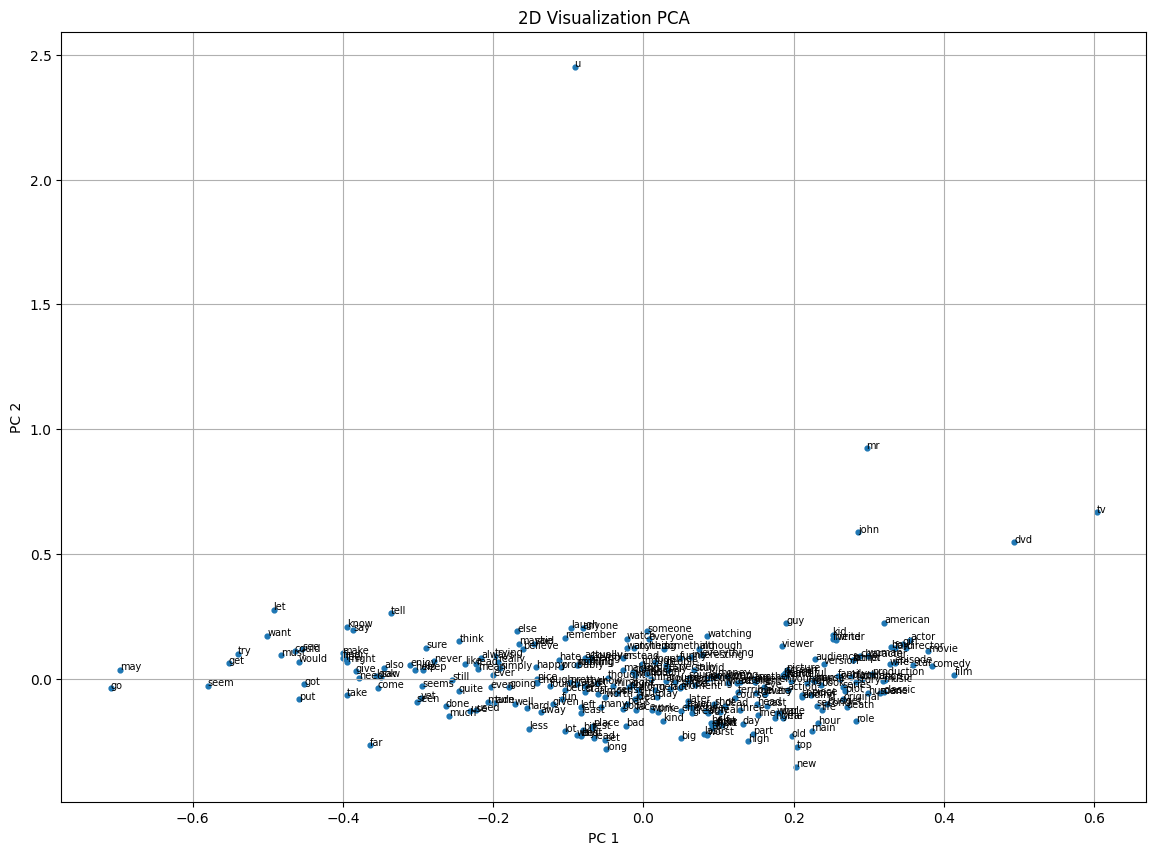

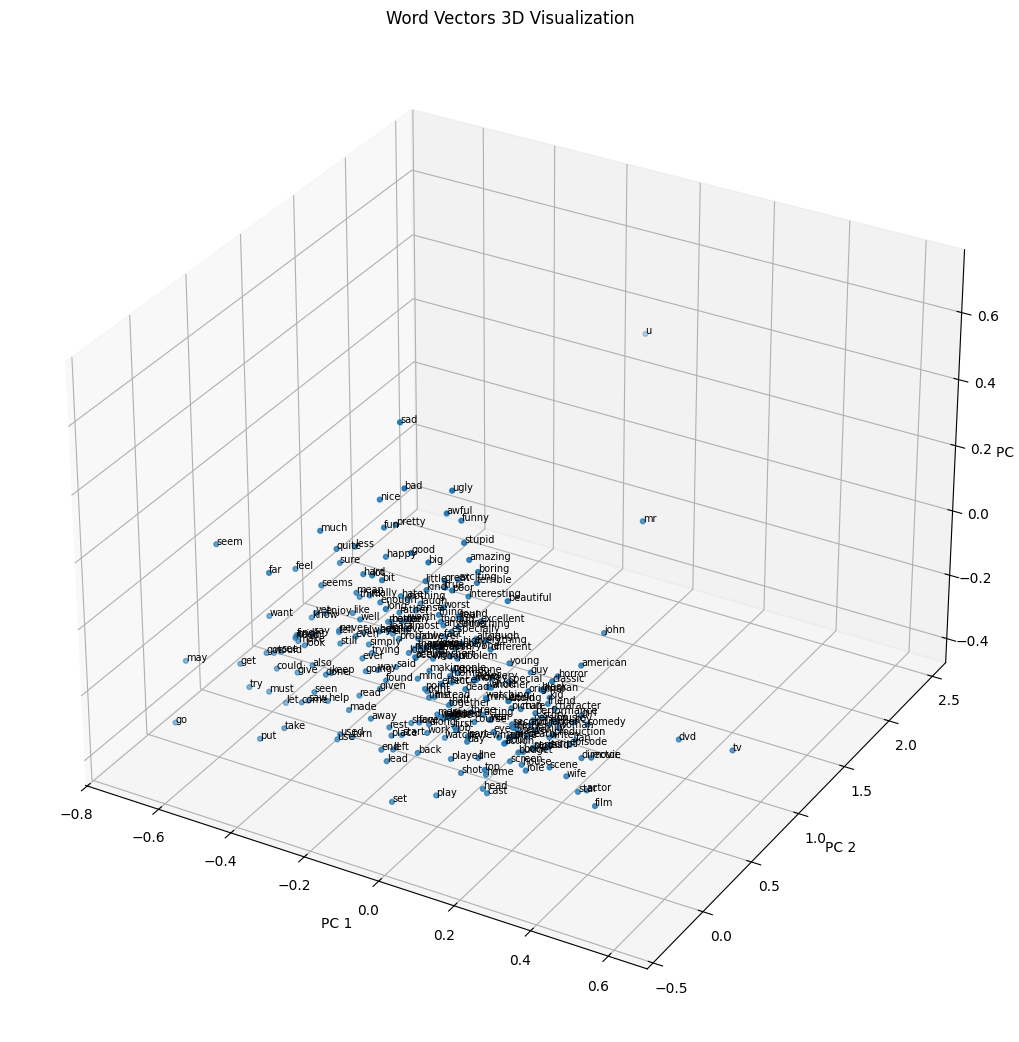

In [14]:
# For 2D visualization, create a scatter plot and annotate each point with its corresponding word to provide context.
plt.figure(figsize=(14, 10))

# Create a scatter plot for 2d
x = X_2d[:, 0]
y = X_2d[:, 1]

plt.scatter(x, y, s=12)


# text annotations
for i, word in enumerate(labels):
    plt.text(x[i], y[i], word, fontsize=7, color='black')

# Plot
plt.title('2D Visualization PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()

# Create a 3D scatter plot using Axes3D
fig = plt.figure(figsize=(14, 10))
ax = Axes3D(fig, auto_add_to_figure=False) 
fig.add_axes(ax)


xs = X_3d[:, 0]
ys = X_3d[:, 1]
zs = X_3d[:, 2]

ax.scatter(xs, ys, zs, s=12)

# text annotations
for i, word in enumerate(labels):
    ax.text(xs[i], ys[i], zs[i], word, fontsize=7, color='black')

# Plot
ax.set_title('Word Vectors 3D Visualization')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

The graph shows that words with similar meanings are clustered together.

Another feature of the graph is that antonyms are observed to be distributed in opposite directions.

These two phenomena indicate that the model possesses the essential discrimination capability required for the sentiment analysis task.

### 4. Creating the Emebdding Matrix (10 points)

In [15]:
import numpy as np
import torch
import torch.nn as nn

# Function to create an embedding matrix
def create_embedding_matrix(word2vec, vocab, embedding_dim):

    vocab_size = len(vocab) 

    # Initialize matrix with random values
    embedding_matrix = np.random.normal(
        scale=0.6,
        size=(vocab_size, embedding_dim)
    )
    # Set padding token to zero
    embedding_matrix[0] = np.zeros(embedding_dim)

    # Fill matrix with pre-trained vectors
    for word in vocab:
        idx = vocab[word]
        if word in word2vec:
            embedding_matrix[idx] = word2vec[word]

    return embedding_matrix
    


In [16]:
# Convert the embedding matrix to a PyTorch tensor
EMBEDDING_DIM = 300


# Generate the embedding matrix
embedding_matrix = create_embedding_matrix(fasttext_vectors, vocab_to_int, EMBEDDING_DIM)

# Convert the numpy matrix to a PyTorch FloatTensor
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

# Create the Embedding layer
embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)



### 5. Implementing the IMDBDataset (5 points)
* Use PyTorch’s Dataset and DataLoader classes to manage the dataset efficiently and create mini-batches for training.

In [17]:
# import necessary imports
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



In [18]:
# Implement the dataset class
class SentimentDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data    
        self.y_data = y_data
        
    def __getitem__(self, index):
        returned_x = self.X_data[index]
        returned_y = self.y_data[index]
        return returned_x, returned_y
        
    def __len__(self):
        return len(self.X_data)

In [19]:

# Convert padded sequences  and labels to PyTorch tensors
X_train = torch.tensor(train_df['padded_indices'].tolist(), dtype=torch.long)
y_train = torch.tensor(train_df['sentiment'].values, dtype=torch.float32)

# Convert padded sequences  and labels to PyTorch tensors
X_val = torch.tensor(val_df['padded_indices'].tolist(), dtype=torch.long)
y_val = torch.tensor(val_df['sentiment'].values, dtype=torch.float32)

# Convert padded sequences  and labels to PyTorch tensors
X_test = torch.tensor(test_df['padded_indices'].tolist(), dtype=torch.long)
y_test = torch.tensor(test_df['sentiment'].values, dtype=torch.float32)

# Instantiate Dataset objects
train_dataset = SentimentDataset(X_train, y_train)
val_dataset = SentimentDataset(X_val, y_val)
test_dataset = SentimentDataset(X_test, y_test)



BATCH_SIZE = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 6. Implementing and Optimizing the Custom LSTM model (35 points)

In [20]:

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # Define weight matrices and biases for each gate
        self.input_size = input_size
        self.hidden_size = hidden_size
        

        combined_size = input_size + hidden_size
        
        # 1. Forget Gate 
        self.xf = nn.Linear(combined_size, hidden_size)
        
        # 2. Input Gate 
        self.xi = nn.Linear(combined_size, hidden_size)
        
        # 3. Cell Candidate 
        self.xc = nn.Linear(combined_size, hidden_size)
        
        # 4. Output Gate 
        self.xo = nn.Linear(combined_size, hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        

        combined = torch.cat((x_t, h_prev), dim=1)
        
        # Forget Gate
        combined_xf_output = self.xf(combined)
        f_t = torch.sigmoid(combined_xf_output)
        
        # Input Gate
        combined_xi_output = self.xi(combined)
        i_t = torch.sigmoid(combined_xi_output)
        
        # Candidate Cell State
        combined_xc_output = self.xc(combined)
        g_t = torch.tanh(combined_xc_output)
        
        # Output Gate
        combined_xo_output = self.xo(combined)
        o_t = torch.sigmoid(combined_xo_output)

        # Necessary Calcs
        kept_memory = i_t * g_t
        new_memory = f_t * c_prev
        c_t = kept_memory + new_memory
        
        h_t = o_t * torch.tanh(c_t)


        return h_t, c_t


In the forward method of the LSTMCell class, I manually implemented the standard LSTM architecture

First, the input vector  and the hidden state from the previous time step are concatenated 

Forget Gate

This gate decides which information to forget and which to keep. It uses a sigmoid function to produce an output between 0 and 1. 0 = completely forget. 1 = completely keep.

Input Gate 

The input gate decides which values we will update with new information

Candidate Cell State

Candidate vector representing the new candidate values that could be added to the state.

Cell State Update

The old cell state is multiplied by the forget gate and we add the new candidate values scaled by the input gate

Output Gate

Finally, the output gate decides what the next hidden state should be

In [21]:


# Custom LSTM Layer
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)

    def forward(self, x):
        
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Initialize hidden state  and cell state 
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

    
        # Stack outputs for all time steps
        outputs = []
        t = 0
        while t < seq_len:
            x_t = x[:, t, :]
            # Update states
            h_t, c_t = self.lstm_cell(x_t, h_t, c_t)
            outputs.append(h_t)
            t += 1
        
        # Stack outputs from all time steps into a single tensor
        outputs_stack = torch.stack(outputs, dim=1)
        return outputs_stack
    



In [22]:
# Main Model Class
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        # Custom LSTM Layer
        self.lstm = LSTMLayer(input_size, hidden_size)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)
        # Sigmoid activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convert indices to dense word vectors
        embedded = self.embedding(x)    
        # Process sequence with LSTM          
        lstm_out = self.lstm(embedded)   
        # Take the hidden state of the last time step        
        last_hidden_state = lstm_out[:, -1, :]      
        # linear layer         
        out = self.fc(last_hidden_state)    
        # Apply Sigmoid        
        return self.sigmoid(out)
    




In [23]:
# Define the hyperparameters 
input_size = 300  # This will be the word vector size
hidden_size = 64
epochs = 75 
learning_rate = 0.01
batch_size = 16

Why unfreeze the embedding layer ? --- Reasons for hyperparameters selections.

For the embedding layer, I chose not to freeze the weights, allowing them to be fine-tuned during training. This way, it learns better. For example, it can even learn vectors for OOV words. However, a downside is that it increases the model capacity too much. When I first tried this, it overfitted immediately even in the first 5 epochs, especially in the 75 epochs I chose. I prevented this problem by taking other measures. For example, I added L2 regularization. I didn't add a dropout because I wasn't sure if it was legal for the assignment. Then, I chose the hidden size and batch size parameters in a way that would prevent the model from overfitting. Another method is to have the model save the best model after each epoch. This way, after 75 epochs, the overfitted model can choose its best model, which is not overfitted.

In [24]:
# Define appropriate loss function for binary classification.
# Choose an optimizer and set its parameters (e.g., learning rate).
# Explain your choice of loss function and optimization algorithm.

import torch

    

# Device choice
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = SentimentLSTM(input_size, hidden_size, 1, embedding_tensor).to(device)

# Loss Function
criterion = nn.BCELoss() 
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)


I used Binary Cross Entropy Loss in this task because it's a Binary Classification problem.


I chose the Adam algorithm for optimization because it converges the model better than other optimizers. I added the `weight_decay=1e-3` parameter to the code. This applies L2 Regularization to the model, which helps prevent overfitting.

In [25]:
num_epochs = epochs 

# Arrays that hold the metrics we will display at the end of each epoch
train_losses = np.zeros(num_epochs)
val_losses   = np.zeros(num_epochs)
train_accs   = np.zeros(num_epochs)
val_accs     = np.zeros(num_epochs)

# For saving the best model
best_acc = 0.0

# Epoch for loop
for epoch in range(num_epochs):
    
    # Train Mode
    model.train()
    running_loss = 0.0 # For loss calculation each epoch
    batch_correct = [] # will hold number of correct predictions per batch  
    batch_sizes = [] # will hold batch sizes

    # Iterate over all mini-batches in the training set
    for i, (inputs, labels) in enumerate(train_loader):

        # Move data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)      

        # Compute loss    
        loss = criterion(outputs.squeeze(), labels)    
        loss.backward() # Backward pass                       
        optimizer.step()   # Update model parameters                    

        # Accumulate total loss for each epoch
        running_loss += loss.item()  * inputs.size(0)

        # Batch size and correct outputs in batch calc
        label_size1 = labels.size(0)
        batch_sizes.append(label_size1)
        
        # Binary Classification Accuracy Logic 
        preds = (outputs.squeeze() > 0.5).float()
        sum1 = (preds == labels).sum()
        batch_correct.append(sum1.item())

    # Compute training accuracy and loss
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = sum(batch_correct) / sum(batch_sizes)

  
    # Evaluation mode 
    model.eval()

    batch_correct_val = [] # will hold number of correct predictions per batch 
    batch_sizes_val = [] # will hold batch sizes
    val_running_loss  = 0.0 # For loss calculation each epoch

    # Do not compute gradient
    with torch.no_grad():
        # Iterate over all mini-batches
        for i, (inputs, labels) in enumerate(val_loader):
            # Move data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

             # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels) # Compute validation loss
            
            # Accumulate validation loss 
            val_running_loss += loss.item()  * inputs.size(0) 

            # Compute predictions and count how many are correct
            preds = (outputs.squeeze() > 0.5).float()
            sum2 = (preds == labels).sum()
            batch_correct_val.append(sum2.item())
            
            label_size = labels.size(0)
            batch_sizes_val.append(label_size)

     # Compute average validation loss and accuracy
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc  = sum(batch_correct_val) / sum(batch_sizes_val)

    # Save metric into numpy arrays
    train_losses[epoch] = epoch_train_loss
    val_losses[epoch]   = epoch_val_loss
    train_accs[epoch]   = epoch_train_acc
    val_accs[epoch]     = epoch_val_acc


     # Print
    print(
    "Epoch " + str(epoch+1) + "/" + str(num_epochs) + "\n" +
    "Train Loss: " + str(epoch_train_loss) + " | Train Acc: " + str(epoch_train_acc) + "\n" +
    "Val Loss: " + str(epoch_val_loss)   + " | Val Acc: " + str(epoch_val_acc)   + "\n"
    )

    # Save best model if there is at the end of each epoch
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_model.pth')

print("Best Accuracy:", best_acc)

Epoch 1/75
Train Loss: 0.6368798955508641 | Train Acc: 0.6385714285714286
Val Loss: 0.6080166540145874 | Val Acc: 0.6735

Epoch 2/75
Train Loss: 0.5725409342902047 | Train Acc: 0.7132857142857143
Val Loss: 0.5667287197113037 | Val Acc: 0.7075

Epoch 3/75
Train Loss: 0.5640487617765154 | Train Acc: 0.7098571428571429
Val Loss: 0.5900318431854248 | Val Acc: 0.6945

Epoch 4/75
Train Loss: 0.6291717490128108 | Train Acc: 0.649
Val Loss: 0.5818695440292359 | Val Acc: 0.685

Epoch 5/75
Train Loss: 0.585942140851702 | Train Acc: 0.6905714285714286
Val Loss: 0.6015295186042786 | Val Acc: 0.677

Epoch 6/75
Train Loss: 0.5138308785302298 | Train Acc: 0.764
Val Loss: 0.6331222491264343 | Val Acc: 0.6385

Epoch 7/75
Train Loss: 0.5494437338284084 | Train Acc: 0.733
Val Loss: 0.5174957032203674 | Val Acc: 0.7555

Epoch 8/75
Train Loss: 0.40680342612947734 | Train Acc: 0.8275714285714286
Val Loss: 0.4167619798183441 | Val Acc: 0.8285

Epoch 9/75
Train Loss: 0.31357212230137416 | Train Acc: 0.8728571

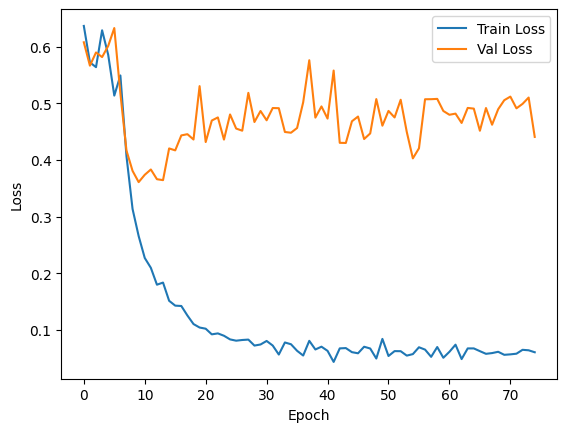

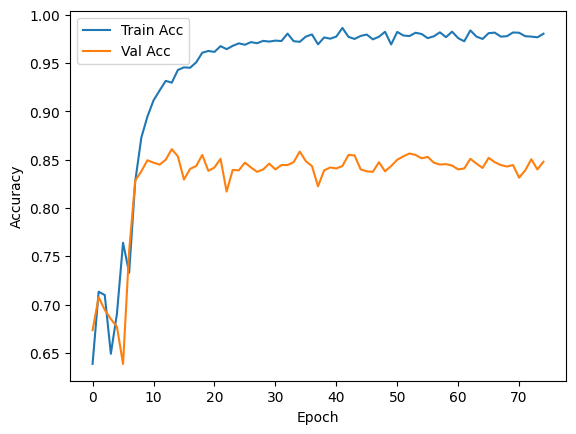

In [26]:
# Visualize the accuracy and loss change of the best model across training and validation datasets
# Make comments on the results

# Plot training and validation loss curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Plot training and validation accuracy curves
plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The training loss reaches a very low value, such as 0.05. This indicates that the LTSM model has learned the training data very well, meaning it is overfitting.

The validation loss decreases initially, reaching its minimum somewhere between Epoch 10 and Epoch 15. Afterwards, it increases slightly to 0.55. This "U-shape" in the validation loss is an overfitting indicator that model has stopped generalizing and started memorizing the training data.

The training accuracy reaches a very high number, around 98 percent. This is an indicator of overfitting after 75 epochs.

The validation accuracy reaches around 86% after 10-15 epochs. After that, it gradually decreases. After 15 epochs, the model has overfitted, but we developed this solution that we saved the best model.

### 7. Testing and Analysis (15 points)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load best model for evaluation
model.load_state_dict(torch.load("best_model.pth", map_location=device))

# Eval mode
model.eval()

# Store predictions and targets 
store_preds = []
store_targets = []

# Do not compute gradient

with torch.no_grad():
    
    for data, target in test_loader: # Iterate over all mini-batches

        # Move data to GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        out = model(data)
        
        prediction_indices = (out.squeeze() > 0.5).long() 
        
        store_preds.append(prediction_indices)
        store_targets.append(target)

# Convert lists to numpy arrays
final_predictions = torch.cat(store_preds).cpu().numpy()
final_targets = torch.cat(store_targets).cpu().numpy()

# Compute evaluation metrics
acc = accuracy_score(final_targets, final_predictions)
prec = precision_score(final_targets, final_predictions, average='binary')
rec  = recall_score(final_targets, final_predictions, average='binary')
f1   = f1_score(final_targets, final_predictions, average='binary')

# Print
print("Accuracy :", acc)
print("Precision :", prec)
print("Recall :", rec)
print("F1 Score :", f1)

Accuracy : 0.868
Precision : 0.859375
Recall : 0.88
F1 Score : 0.8695652173913043


The model was trained for 75 epochs.

The model performed very well on the training set, with a final accuracy of 98% and a loss of 0.05. This indicates that the LSTM model learned and memorized the training dataset. This is quite possible given the small dataset size; in other words, our dataset is very prone to overfitting.

The validation accuracy peaked around 86% in the earlier epochs but ended lower at 81% with a loss of 0.55 in the final epoch. This wasn't a major problem since we saved the "Best Model".

The model evaluated on the test set was the "Best Model" saved during training. It achieved an accuracy of 85%. The precision was 0.84, recall was 0.85, and the F1 score was 0.85.

Findings:

The model was essentially overfitted after 75 epochs. But we solved this problem through best model saving and other measures we used.

While the Training Loss decreases monotonically throughout the 75 epochs, the Validation Loss reaches a minimum around Epoch 15 and increased after Epoch 15. So after Epoch 15, the model stopped learning generalizable features and began fitting to the noise in the training data.

Similarly, the Training Accuracy climbs to ~98%, while the Validation Accuracy oscillated between 82 and 85. This indicates overfitting.

We observed the same result in our test set as we found in our validation set. Test Set results accuracy are higher than the final Validation accuracy because we evaluated our test set with our best model.

Class Balance The Test metrics show a very small difference between Precision and Recall. This indicates that the model is unbiased; it is equally good at identifying positive reviews as it is at identifying negative ones.

Challenges and Areas for Improvement:

First of all, since our dataset is small, our model is very prone to overfitting. In the initial training, after 2-3 epochs, the model was memorizing the training dataset. To change this, I tried different combinations of hyperparameters, approximately 20-30 combinations. Considering that each training session was at least 30 minutes, this shows that I spent a considerable amount of time training the model. I didn't just combine hyperparameters; I added L2 regularization and found other solutions for this problem, but it still overfitted after 15-20 epochs. And I saved my best model in these epochs.

Another challenge was choosing the 95th percentile for padding, which meant some very long reviews were truncated, potentially losing sentiment information.

Regarding areas for improvement, we could increase the dataset for better generalization. We could use dropouts. I didn't use dropouts in this task because I wasn't sure if it was legal for the assignment.

Using a bidirectional LSTM: Currently, the model only processes the text from beginning to end. Using a Bi-LSTM would allow the network to capture context from both directions, resulting in improved performance.

### 8. Testing on Kaggle (5 points)

* Put your Kaggle test result for your model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

# Load the test dataset
test_file_path = 'subset1000_IMDB_Dataset.csv'  
test_df = pd.read_csv(test_file_path)

# Apply the preprocessing
test_df['tokens'] = test_df['review'].apply(prepocess_text)

# Convert tokens to integer indices and apply padding
test_indices = prepare_data(test_df['tokens'], vocab_to_int, MAX_LEN)

# Convert processed data to PyTorch LongTensor
X_test_tensor = torch.tensor(test_indices, dtype=torch.long)

# Re-initialize the model architecture
model = SentimentLSTM(input_size, hidden_size, 1, embedding_tensor).to(device)

# Load the best trained weights
model_path = 'best_model.pth' 
model.load_state_dict(torch.load(model_path))
model.eval() 


batch_size = 32

# Create DataLoader
test_loader1 = DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)


predictions = []
with torch.no_grad():# Disable gradient calculation
    for batch_inputs in test_loader1:
        
        batch_inputs = batch_inputs.to(device)
        
        # Forward pass
        outputs = model(batch_inputs)
        
        # Generate predictions
        preds = (outputs.squeeze() > 0.5).long().cpu().tolist()
        
        
        if isinstance(preds, int):
            preds = [preds]
            
        predictions.extend(preds)

# Map numerical predictions to string labels
class_labels = {0: 'negative', 1: 'positive'}
mapped_predictions = [class_labels[p] for p in predictions]


submission_df = pd.DataFrame({
    'ID': range(1, len(mapped_predictions) + 1), 
    'sentiment': mapped_predictions
})
# Create submission.
submission_df.to_csv('submission.csv', index=False)


print(submission_df.head())

   ID sentiment
0   1  positive
1   2  positive
2   3  negative
3   4  negative
4   5  positive


The model achieved a high accuracy of 94.6% on the Kaggle submission test set.

There is a nearly 10 percent difference in kaggle test score and our test score. This is unusual. One of the reasons for this is that The Kaggle test may consist of easier-to-classify reviews compared to the our test set.

Overall, the model I trained did a good job on the Kaggle test set.

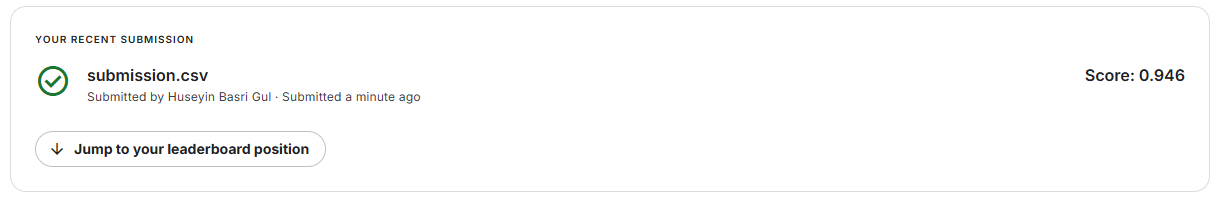

### 9. Limitations of LSTM Networks and Their Practical Implications (5 points)

### Key Limitations of LSTMs


Sequential Processing Bottleneck:

The biggest limitation is that LSTMs have to process data sequentially. This can be explained as follows: The hidden state at time t depends on the previous ht. This sequential dependency prevents parallelization. This leads to inefficient use of parallelization, which is the greatest feature of GPUs.

Fixed-Vector Bottleneck:

Another limitation is this. This means that no matter how long the input sequence is, all the information must be compressed into a single fixed-size vector, i.e., the final hidden state. This can cause a very critical thing mentioned at the beginning of our task to be forgotten, which is a highly undesirable situation.

Computational Cost:

The mathematical cost of an LSTM cell is higher compared to its competitors. It requires four separate matrix multiplications for four different gates at each time step. This increases the training time.

### Limitations Observed in Experiments

Overfitting:

As can be seen from the training graphs, our model has an overfitting problem. While our model reduced the Training Loss to approximately 0.05, the Validation Loss increased to approximately 0.55 after the 15th epoch. These problems arose because I did not use methods that reduce model capacity, such as dropout, and the dataset was very small.

Training Latency:

Because LTSM cell calculations are costly and we wrote this class manually ourselves, the training time was very long. In my case, it took even longer to train, especially since I assigned a large number of epochs.




### Addressing Issues in Contemporary NLP

Modern architectures, primarily Transformers, overcome this problem.

Parallelization via Attention:

Transformers replace recurrence with the Self-Attention mechanism. This allows all tokens to be processed in parallel, fully utilizing the power of GPUs.

Fixed-Vector Solution:

Instead of compressing information into a single vector, the Attention mechanism allows the model to directly look each word. This solves the fixed-vector problem described above.

### Real-World Scenarios

LSTMs remain highly practical in low-latency streaming applications on edge devices, such as wake-word detection.

Streaming Requirement:

In a wake-word scenario, audio data arrives continuously as an infinite stream. A Transformer has more complexity than an LSTM because it simply updates its hidden state based on ht-1 and the new input xt, making it perfect for this type of situation.

Hardware/Memory Constraints:

It is not possible to store attention matrices on devices with low RAM and low hardware specifications, such as phones. LSTMs are more efficient in these situations because they only store the current state in memory.